<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de Q-learning sobre el entorno Frozen Lake

*Description*: En este notebook se desarrolla la implementación del método de **Q-Learning**, y se emplea sobre el entorno Frozen Lake de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09


In [37]:
%%capture
!pip install 'gym[box2d]==0.20.0'

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


In [39]:
# Intentamos fijar las semillas
import os
import torch

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

SEED = 123

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

Usando dispositivo: cpu


## Definición del agente

Como alternativa a SARSA, dentro de los **métodos de Diferencias Temporales** tenemos a **Q-learning** que, al contrario que SARSA, se trata de un método Off-Policy.

Para la **política de comportamiento** podemos usar cualquiera que explore, nosotros usamos una $\epsilon$-greedy, porque podemos adaptarla a una uniforme si quisiéramos, con $\epsilon=1$. Para la **política objetivo** establecemos una greedy.

La actualización de los valores $Q$, se lleva a cabo de la siguiente manera:

$$
Q(S_t, A_t) ← Q(S_t, A_t) + \alpha (R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t))
$$

In [40]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

class AgentQ_learning:
  def __init__(self,
               env:gym.Env,
               epsilon:float,
               alpha:float,
               gamma:float,
               decay:bool
               ):

    # Inicializamos atributos del agente
    self.env = env
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.decay = decay

    # Inicializamos tabla Q (para entornos discretos)
    self.n_states = env.observation_space.n
    self.n_actions = env.action_space.n
    self.Q = np.zeros((self.n_states, self.n_actions))

  def get_Q(self):
    return self.Q

  def get_epsilon(self):
    return self.epsilon


  # Usando política epsilon-greedy
  def get_action(self, state):
    # Con probabilidad epsilon se escoge una acción aleatoria (exploración)
    if np.random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      # Con probabilidad 1-epsilon se escoge la mejor acción (explotación)
      return np.argmax(self.Q[state])

  def greedy_policy(self, state):
    return np.argmax(self.Q[state])

  # Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
  def get_action_greedy_from_Q(self, env):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(self.Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

  # Función de actualización episódica (observese que se necesita la información del siguiente estado-accion)
  def update(self, state, action, reward, next_state, done):
    current_q = self.Q[state, action]
    max_next_q = np.max(self.Q[next_state]) if not done else 0
    # Slide 26
    self.Q[state, action] = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)


## Esquema general del aprendizaje episódico de un agente (Algoritmo)

El esquema general de aprendizaje también varía con respecto a SARSA, pues la acción a tomar al inicio del bucle se obtiene en esa misma iteración, y no en la iteración anterior como hacía SARSA. La actualización de valores se realiza de manera episódica como SARSA.

In [41]:
def train(agent, num_episodes):
  stats = 0.0
  list_stats = [stats]
  list_len = []
  step_display = num_episodes / 10
  np.random.seed(SEED)

  # Ejecutamos n_episodes
  for t in tqdm(range(n_episodes)):
    state, info = agent.env.reset(seed=SEED)
    done = False

    len_episode = 0
    total_reward = 0

    # play one episode
    while not done:

      action = agent.get_action(state)
      # Tomamos la acción obtenida en el paso anterior
      next_state, reward, terminated, truncated, info = agent.env.step(action)

      # Actualizamos la tabla Q
      agent.update(state, action, reward, next_state, terminated)

      # S <- S'
      state = next_state

      total_reward += reward

      # update if the environment is done and the current obs
      done = terminated or truncated

      len_episode += 1

    # Decaimiento de epsilon
    if agent.decay:
      agent.epsilon = min(agent.epsilon, 1000/(t+1))

    # Guardamos datos sobre la evolución
    stats += total_reward
    list_stats.append(stats/(t+1))
    list_len.append(len_episode)

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if t % step_display == 0 and t != 0:
      print(f"Recompensa promedio: {stats/t}, epsilon: {agent.get_epsilon()}")

  return list_stats, list_len

In [42]:
# Para la visualización del video

def run_episode_greedy(agent, max_steps=100):
  frames = []
  state, info = agent.env.reset(seed=SEED)

  total_reward = 0.0
  len_episode = 0

  for t in range(max_steps):
    frame = agent.env.render()
    frames.append(frame)
    action = agent.greedy_policy(state)
    next_state, reward, done, truncated, info = agent.env.step(action)
    total_reward += reward
    state = next_state
    len_episode += 1

  frames.append(agent.env.render())
  agent.env.close()

  return total_reward, len_episode, frames

## Funciones auxiliares

Funciones comúnes que usaremos en todos los notebooks. Serán para visualizar la política greedy final obtenida, el vídeo del comportamiento final del agente, así como las gráficas que nos provean de información intuitiva de la evolución del proceso de aprendizaje.

In [43]:
def qtable_directions_map(qtable, map_size):
    '''
      Para cada estado del mapa (cada celda) nos devuelva la dirección que debe coger el
      agente según la política obtenida.
    '''
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine

    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]

    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [44]:
import seaborn as sns

def plot_q_values_map(qtable, env, map_size):
    '''
      Ploteamos el último frame del camino que realizaría el agente, junto con un
      las direcciones que toma en función del estado en el que se encuentre, y evaluar.
    '''
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    #img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    #fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [45]:
import imageio

def frames_to_gif(frames, filename="FL_QL.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [46]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [47]:
def plot(list_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(10, 4))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

def plot_comparative(dict_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios de cada elemento de la lista.
    list_stats: Es un diccionario, donde cada clave contiene la información de un agente.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(dict_stats['eps=0.4, decay=True'])))
  plt.figure(figsize=(10, 4))

  for key in dict_stats:
    plt.plot(indices, dict_stats[key], label=key)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')
  plt.legend()

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [48]:
from scipy import stats

def moving_average(data, window_size):
    '''
      Calcula la media móvil de una serie de datos, para una window_size dada.
    '''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_len_tendency(list_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia.
  '''

  plt.figure(figsize=(10, 4))

  plt.plot(list_len, alpha=0.3, color='green')

  # Curva de media móvil
  window = 100
  avg = moving_average(list_len, window_size=window)
  plt.plot(range(len(avg)), avg, label="Longitud del episodio", color='darkgreen', linewidth=2)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_len_comparative(dict_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia, de cada elemento del diccionario.
  '''
  color = ['darkred', 'darkblue', 'darkgreen']

  plt.figure(figsize=(10, 4))
  # Curva de media móvil
  window = 100
  for i, key in enumerate(dict_len):
    plt.plot(dict_len[key], alpha=0.2, color=color[i])
    avg = moving_average(dict_len[key], window_size=window)
    plt.plot(range(len(avg)), avg, label=key, linewidth=2, color=color[i])

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

## Caso de estudio: Entorno FrozenLake

In [49]:
# Fijar la semilla en Gymnasium
def make_env_fl(env_name, map="4x4", render = "ansi", is_slippery=False, max_episode_steps=100):
  env = gym.make(env_name, is_slippery=is_slippery, map_name=map, render_mode=render, max_episode_steps=max_episode_steps)
  env.reset(seed=SEED) # Establece la semilla en el entorno de Gymnasium
  return env

name_fl = 'FrozenLake-v1'

In [50]:
env4 = make_env_fl(name_fl, "4x4", "rgb_array")

In [51]:
agent_4 = AgentQ_learning(env4, epsilon=1.0, alpha=0.1, gamma=0.99, decay=True)

### Caso 4x4

In [52]:
n_episodes = 50000
list_stats_4, list_len_4 = train(agent_4, n_episodes)

 11%|█         | 5384/50000 [00:01<00:17, 2504.15it/s]

Recompensa promedio: 0.4346, epsilon: 0.19996000799840033


 20%|██        | 10061/50000 [00:04<00:37, 1069.43it/s]

Recompensa promedio: 0.6459, epsilon: 0.0999900009999


 31%|███       | 15514/50000 [00:06<00:14, 2344.35it/s]

Recompensa promedio: 0.735, epsilon: 0.06666222251849876


 41%|████      | 20474/50000 [00:09<00:11, 2492.52it/s]

Recompensa promedio: 0.7863, epsilon: 0.04999750012499375


 50%|█████     | 25152/50000 [00:11<00:08, 2882.21it/s]

Recompensa promedio: 0.81916, epsilon: 0.03999840006399744


 61%|██████    | 30531/50000 [00:14<00:08, 2340.29it/s]

Recompensa promedio: 0.8427666666666667, epsilon: 0.033332222259258026


 72%|███████▏  | 35978/50000 [00:15<00:02, 5475.79it/s]

Recompensa promedio: 0.8610857142857142, epsilon: 0.02857061226822091


 81%|████████  | 40532/50000 [00:16<00:01, 5791.98it/s]

Recompensa promedio: 0.875175, epsilon: 0.02499937501562461


 92%|█████████▏| 46004/50000 [00:17<00:00, 5626.37it/s]

Recompensa promedio: 0.8864222222222222, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:18<00:00, 2768.46it/s]


Funciones plot

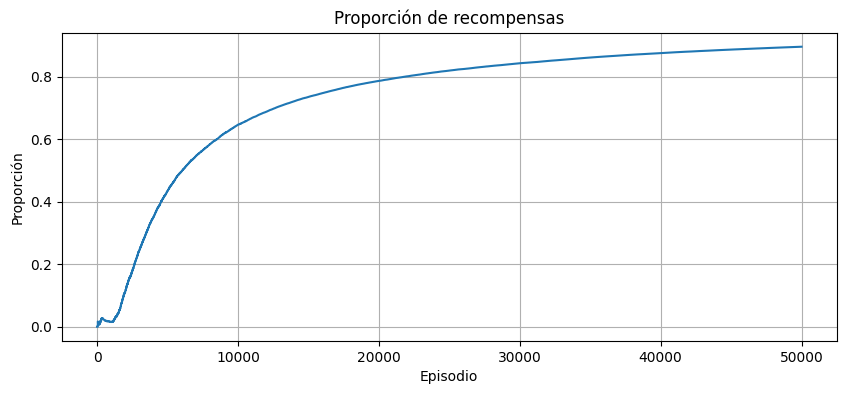

Máxima proporcion: 0.89558


In [53]:
plot(list_stats_4)
print(f"Máxima proporcion: {list_stats_4[-1]}")

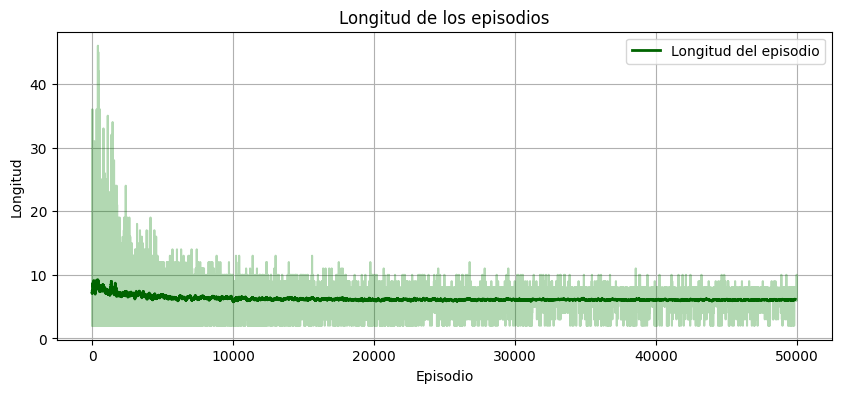

Longitud del último episodio: 6


In [54]:
plot_len_tendency(list_len_4)
print(f"Longitud del último episodio: {list_len_4[-1]}")

## Evaluación 4x4

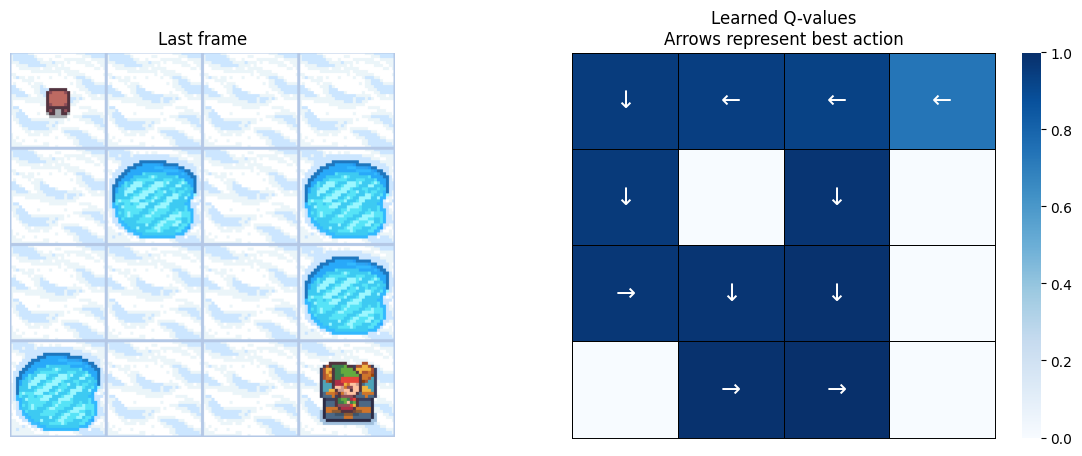

In [55]:
plot_q_values_map(agent_4.get_Q(), env4, 4)

In [56]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_4)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_4 = frames_to_gif(frames, "FL_4x4_QL.gif")
print("GIF guardado en:", gif_path_4)

GIF guardado en: FL_4x4_QL.gif


In [57]:
display_gif(gif_path_4)

### Caso 8x8

In [68]:
env8 = make_env_fl(name_fl, "8x8", "rgb_array", max_episode_steps=100)

In [71]:
agent_8 = AgentQ_learning(env8, epsilon=1.0, alpha=0.1, gamma=0.99, decay=True)

In [72]:
n_episodes = 50000
list_stats_8, list_len_8 = train(agent_8, n_episodes)

 11%|█▏        | 5669/50000 [00:02<00:16, 2725.87it/s]

Recompensa promedio: 0.4554, epsilon: 0.19996000799840033


 21%|██        | 10298/50000 [00:04<00:14, 2668.56it/s]

Recompensa promedio: 0.6513, epsilon: 0.0999900009999


 31%|███       | 15579/50000 [00:06<00:12, 2714.09it/s]

Recompensa promedio: 0.7298, epsilon: 0.06666222251849876


 41%|████      | 20316/50000 [00:08<00:11, 2614.70it/s]

Recompensa promedio: 0.7745, epsilon: 0.04999750012499375


 51%|█████▏    | 25645/50000 [00:10<00:08, 2735.72it/s]

Recompensa promedio: 0.80552, epsilon: 0.03999840006399744


 61%|██████    | 30404/50000 [00:12<00:07, 2782.40it/s]

Recompensa promedio: 0.8281666666666667, epsilon: 0.033332222259258026


 71%|███████   | 35293/50000 [00:13<00:04, 3027.07it/s]

Recompensa promedio: 0.846, epsilon: 0.02857061226822091


 82%|████████▏ | 40755/50000 [00:15<00:02, 3289.61it/s]

Recompensa promedio: 0.860125, epsilon: 0.02499937501562461


 91%|█████████ | 45333/50000 [00:17<00:02, 2162.13it/s]

Recompensa promedio: 0.8711333333333333, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:19<00:00, 2554.05it/s]


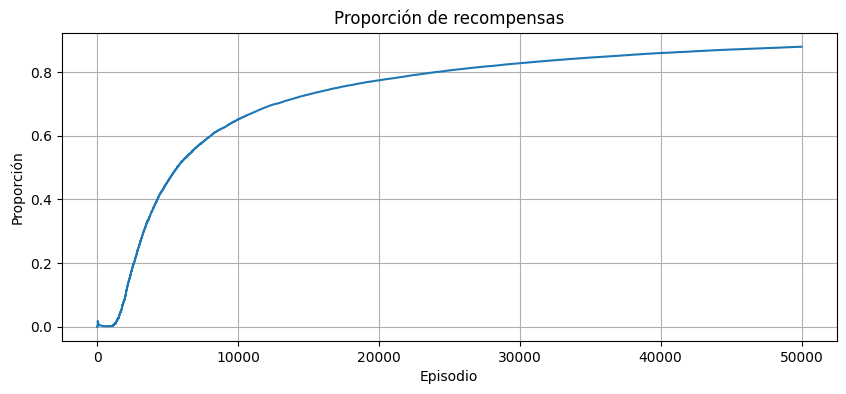

Máxima proporcion: 0.88


In [73]:
plot(list_stats_8)
print(f"Máxima proporcion: {list_stats_8[-1]}")

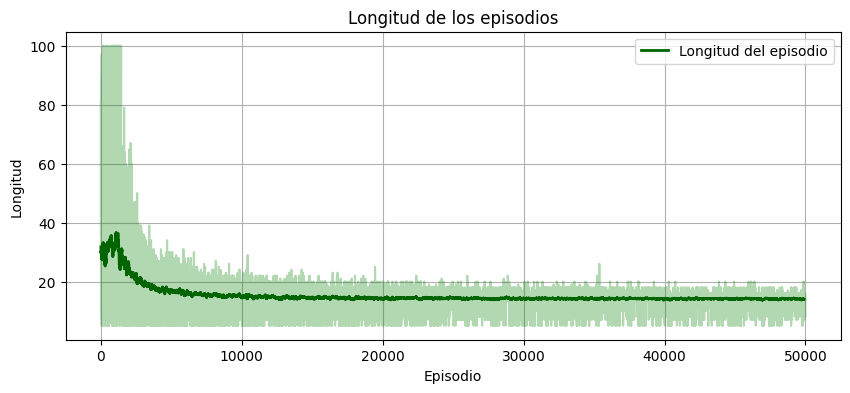

Longitud del último episodio: 14


In [74]:
plot_len_tendency(list_len_8)
print(f"Longitud del último episodio: {list_len_8[-1]}")

## Evaluación 8x8

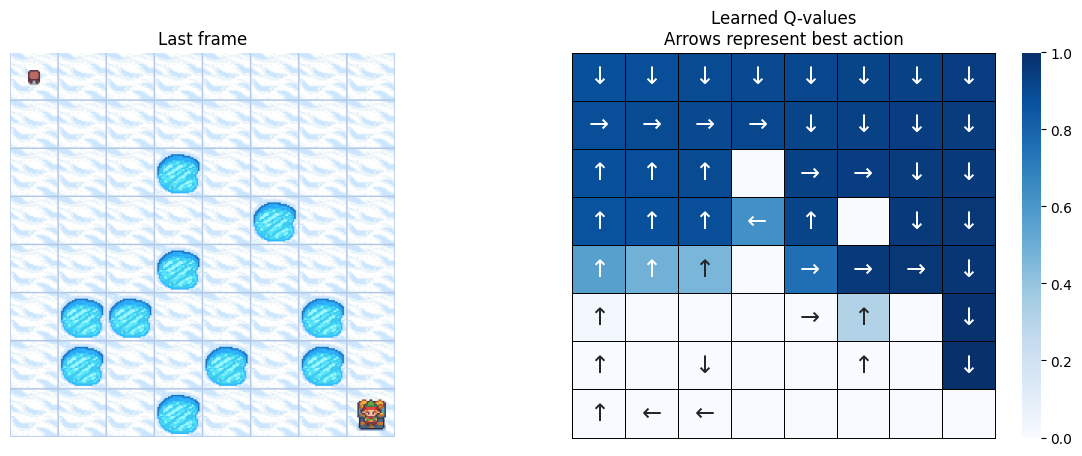

In [75]:
plot_q_values_map(agent_8.get_Q(), env8, 8)

In [76]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_8)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_8 = frames_to_gif(frames, "FL_8x8_QL.gif")
print("GIF guardado en:", gif_path_8)

GIF guardado en: FL_8x8_QL.gif


In [77]:
display_gif(gif_path_8)

Almacenamos las listas con los resultados para su posterior estudio.

In [78]:
import pickle

with open("stats_4_QL.pkl", "wb") as f:
    pickle.dump(list_stats_4, f)

with open("len_4_QL.pkl", "wb") as f:
    pickle.dump(list_len_4, f)

with open("stats_8_QL.pkl", "wb") as f:
    pickle.dump(list_stats_8, f)

with open("len_8_QL.pkl", "wb") as f:
    pickle.dump(list_len_8, f)